### geoid correction using pixc data.
1. centeralization of geoid height;   
2. pixc geoid correction (mean(geoid) + centered geoid height). 
3. pixc to raster, and temporal smoothing for corrected geoid.
4. obtain final raster-based corrected geoid.   

In [2]:
from glob import glob
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils.pixc2raster import pixc2raster
from utils.functions import meter2deg



In [19]:
path_lake_vec = 'data/siling_co-lake/hydrolake_siling_co.gpkg'
dir_pixc = 'data/siling_co-lake/swot-pixc'
paths_pixc_filtered = sorted(glob(dir_pixc + '/*masked_filtered.nc'))  # Get the first .nc file in the directory
print(len(paths_pixc_filtered))
paths_pixc_filtered[0]


2


'data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_015_217_210L_20240516T015222_20240516T015234_PIC0_01_masked_filtered.nc'

In [20]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)


### 1. calculate the corrected geoid for pixc data

In [21]:
## calculate the corrected geoid 
pixcs_geoid_cor_ds = []
for path in paths_pixc_filtered:
    pixc_filtered_nc = xr.open_dataset(path)
    pixc_geoid_cor_ds = pixc_filtered_nc[['pixc_height_cor_filter2', 'geoid']]
    ## calculate corrected geoid
    pixc_ellip_height =  pixc_filtered_nc['pixc_height_cor_filter2'].values + pixc_filtered_nc['geoid'].values        
    pixc_geoid_height_centered = pixc_ellip_height - np.nanmean(pixc_ellip_height)  # Centralization of the geoid height
    pixc_geoid_mean = np.nanmean(pixc_filtered_nc['geoid'])  
    pixc_geoid_cor = pixc_geoid_mean + pixc_geoid_height_centered    ## Geoid correction
    ## save as DataArray
    pixc_geoid_cor_ds = pixc_geoid_cor_ds.assign({'geoid_cor': (("points",), pixc_geoid_cor)})
    pixcs_geoid_cor_ds.append(pixc_geoid_cor_ds)


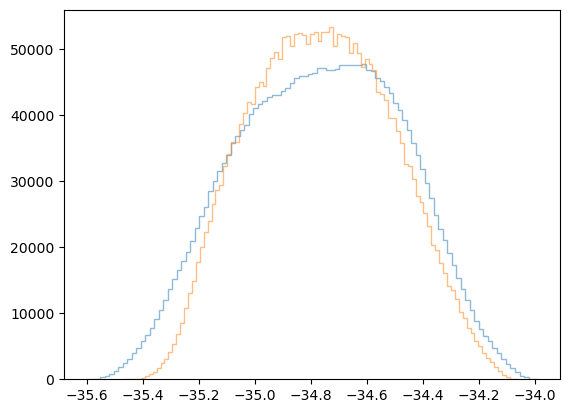

In [23]:
plt.hist(pixcs_geoid_cor_ds[0]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
plt.hist(pixcs_geoid_cor_ds[1]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
# plt.hist(pixcs_geoid_cor_ds[2]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
# plt.hist(pixcs_geoid_cor_ds[3]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');
# plt.hist(pixcs_geoid_cor_ds[4]['geoid_cor'].values, bins=100, alpha=0.5, histtype='step');



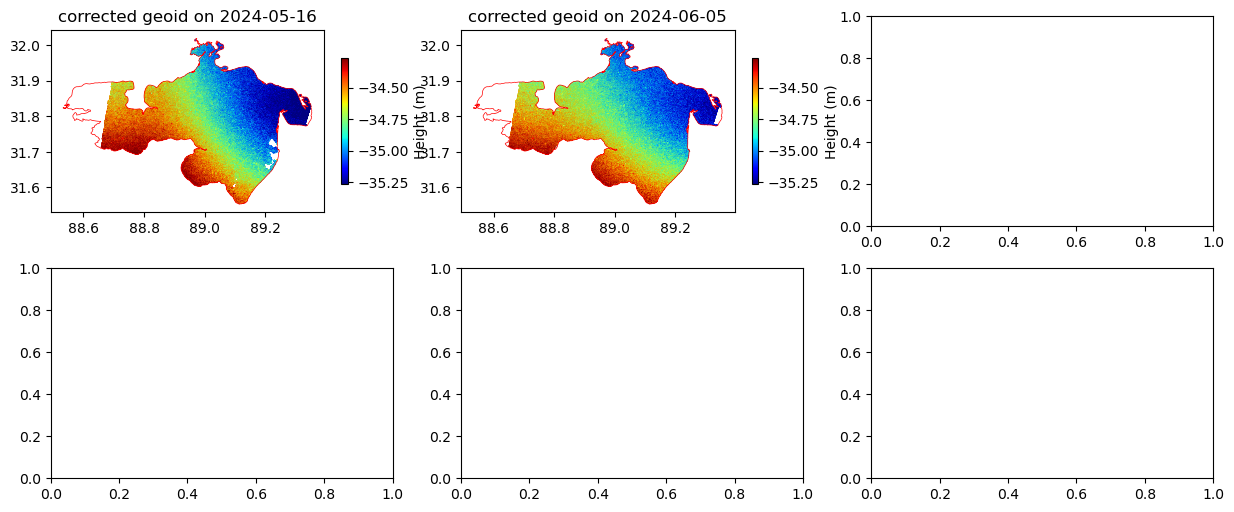

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
geoid_cor_median = np.nanmedian(pixcs_geoid_cor_ds[1]['geoid_cor'].values)
for i in range(2):
  for j in range(3):
    idx = i*3 + j
    if idx >= len(pixcs_geoid_cor_ds): break
    scat = ax[i][j].scatter(x=pixcs_geoid_cor_ds[idx].longitude, y=pixcs_geoid_cor_ds[idx].latitude, 
                          c=pixcs_geoid_cor_ds[idx]['geoid_cor'].values,
                          s=0.5, edgecolor='none', cmap='jet',
                          vmin=geoid_cor_median-0.5, vmax=geoid_cor_median+0.5
                          )
    lake_gdf.plot(ax=ax[i][j], color='none', edgecolor='red', linewidth=0.5)
    plt.colorbar(scat, label='Height (m)', shrink=0.6) 
    ax[i][j].set_title('corrected geoid on ' + pixcs_geoid_cor_ds[idx].attrs['date'])


### 2. perform temporal smoothing for the corrected geoids.

In [25]:
xmin, ymin, xmax, ymax = lake_gdf.geometry[0].buffer(0.01).bounds
raster_extent = (xmin, xmax, ymin, ymax)
print('raster extent:', raster_extent)
lat_center = pixcs_geoid_cor_ds[0]['geoid_cor'].latitude.mean().values
res_lon, res_lat = meter2deg(meter=500, lat=lat_center)
print('resolution (lon, lat):', res_lon, res_lat)


raster extent: (88.52279004460901, 89.36459400967644, 31.543057952710548, 32.028777144282756)
resolution (lon, lat): 0.00529014039826219 0.004496608029593653


In [26]:
## convert pixc data to raster
rasters_geoid_cor = []
for pixc_geoid_cor in pixcs_geoid_cor_ds:
    raster_geoid_cor = pixc2raster(pixc_var = pixc_geoid_cor['geoid_cor'], 
                          raster_extent=raster_extent,
                          pixc_lonlat=(pixc_geoid_cor.longitude.values, pixc_geoid_cor.latitude.values), 
                          resolution=(res_lon, res_lat))
    raster_geoid_cor.attrs = pixc_geoid_cor.attrs
    rasters_geoid_cor.append(raster_geoid_cor)

## convert pixc geoid to raster geoid
raster_geoid = pixc2raster(pixc_var = pixc_geoid_cor['geoid'], 
                      raster_extent=raster_extent,
                      pixc_lonlat=(pixc_geoid_cor['geoid'].longitude.values, pixc_geoid_cor['geoid'].latitude.values), 
                      resolution=(res_lon, res_lat))
raster_geoid



<xarray.DataArray (y: 109, x: 160)> Size: 140kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 1kB 88.52 88.53 88.53 88.54 ... 89.35 89.35 89.36 89.36
  * y        (y) float64 872B 32.03 32.02 32.02 32.02 ... 31.55 31.55 31.54

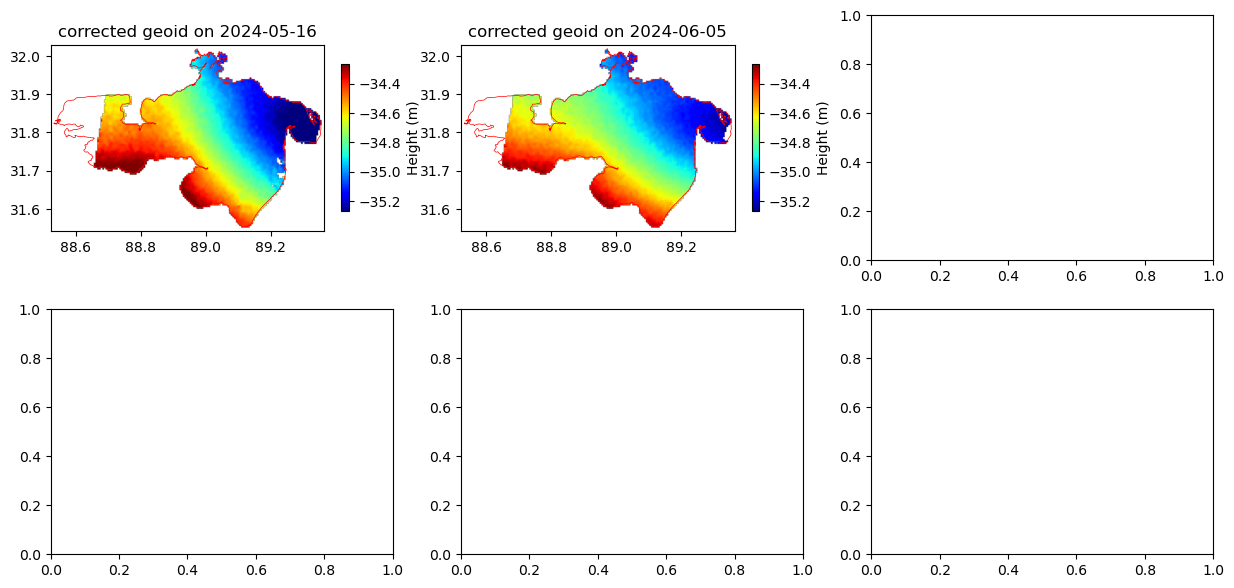

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
geoid_cor_mean = np.nanmean(pixcs_geoid_cor_ds[0]['geoid_cor'].values)
range_color = 1
for i in range(2):
  for j in range(3):
    idx = i * 3 + j
    if idx >= len(rasters_geoid_cor): break
    ## ax1
    im_show = ax[i][j].imshow(rasters_geoid_cor[idx], 
                                  cmap='jet', extent=raster_extent,
                                  vmin=geoid_cor_mean-range_color/2, 
                                  vmax=geoid_cor_mean+range_color/2)
    lake_gdf.plot(ax=ax[i][j], color='none', edgecolor='red', linewidth=0.5)
    plt.colorbar(im_show, label='Height (m)', shrink=0.6)
    ax[i][j].set_title('corrected geoid on ' + rasters_geoid_cor[idx].date)


In [28]:
## temporal smoothing using median filter
rasters_geoid_cor_da = xr.concat(rasters_geoid_cor, dim='date') 
raster_geoid_cor_smoothed = rasters_geoid_cor_da.median(dim='date', keep_attrs=True)  # temporal smoothing
raster_geoid_cor_smoothed.name = "geoid_cor_smoothed"
raster_geoid_cor_smoothed


<xarray.DataArray 'geoid_cor_smoothed' (y: 109, x: 160)> Size: 140kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 1kB 88.52 88.53 88.53 88.54 ... 89.35 89.35 89.36 89.36
  * y        (y) float64 872B 32.03 32.02 32.02 32.02 ... 31.55 31.55 31.54
Attributes:
    date:     2024-05-16

In [29]:
raster_geoid_ds = xr.Dataset({
    'geoid': raster_geoid.rename('geoid'),
    'geoid_cor_smoothed': raster_geoid_cor_smoothed.rename('geoid_cor_smoothed')
})
raster_geoid_ds


<xarray.Dataset> Size: 281kB
Dimensions:             (x: 160, y: 109)
Coordinates:
  * x                   (x) float64 1kB 88.52 88.53 88.53 ... 89.35 89.36 89.36
  * y                   (y) float64 872B 32.03 32.02 32.02 ... 31.55 31.55 31.54
Data variables:
    geoid               (y, x) float64 140kB nan nan nan nan ... nan nan nan nan
    geoid_cor_smoothed  (y, x) float64 140kB nan nan nan nan ... nan nan nan nan

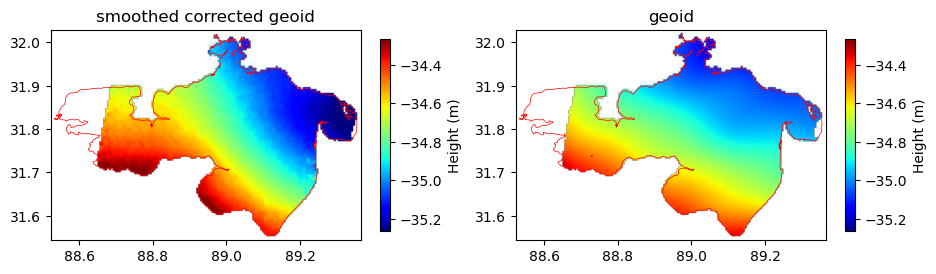

In [30]:
fig, ax = plt.subplots(1,2,figsize=(11, 5))
## ax1
scat1 = ax[0].imshow(raster_geoid_ds['geoid_cor_smoothed'], cmap='jet', extent=raster_extent,
             vmin=geoid_cor_median-0.5, vmax=geoid_cor_median+0.5
             )
lake_gdf.plot(ax=ax[0], color='none', edgecolor='red', linewidth=0.5)
ax[0].set_title('smoothed corrected geoid')
plt.colorbar(scat1, ax=ax[0], label='Height (m)', shrink=0.5)
# ax2
scat2 = ax[1].imshow(raster_geoid_ds['geoid'], cmap='jet', extent=raster_extent,
             vmin=geoid_cor_median-0.5, vmax=geoid_cor_median+0.5
             )

lake_gdf.plot(ax=ax[1], color='none', edgecolor='red', linewidth=0.5)
ax[1].set_title('geoid')
plt.colorbar(scat2, ax=ax[1], label='Height (m)', shrink=0.5)


In [31]:
# Save as NetCDF file
path_raster_geoid_cor_smoothed = dir_pixc + '/raster_geoid_cor_smoothed.nc'
raster_geoid_ds.to_netcdf(path_raster_geoid_cor_smoothed)
